In [66]:
import relation_analysis as ra
import importlib
import numpy as np
importlib.reload(ra)
import warnings
warnings.filterwarnings('ignore')

## Parameters for invoking the notebook

- `cskg_connected`: file path of cskg_connected.tsv (contains the raw cskg edge information)
- `cskg_lexicalized`: file path of cskg_lexicalized.tsv (contains the lexicalized edges, not raw data but generated by methods)
- `edge_embeddings_bert`: file path of edge_embeddings_bert.tsv (contains edge id and its embeddings generated by sentence-transformer-bert on CSKG, not raw data but generated by methods )
- `edge_embeddings_roberta`: file path of edge_embeddings_robert.tsv (contains edge id and its embeddings generated by sentence-transformer-roberta on CSKG, not raw data but generated by methods )
- `cskg_connected_dim`: file path of cskg_connected_dim.tsv.gz (contains the cluster labels for edges on CSKG by human labeling.)
- `log_path`: a folder keeps tensorboard projector's configuration

In [43]:
cskg_connected = '../input/cskg_connected.tsv'
cskg_lexicalized = '../output/cskg_lexicalized.tsv'
edge_embeddings_bert = '../output/edge_embeddings_bert.tsv'
edge_embeddings_roberta = '../output/edge_embeddings_roberta.tsv'
cskg_connected_dim = '../input/cskg_connected_dim.tsv.gz'
log_path = '../output/log_roberta'

## Load CSKD edges 

- `edge_list`:  A list contain multiple tuples kepping each edge's nodes and relation information each tuple's format is  (edge_id, node1_lbl, rel_lbl, node2_lbl, rel_meta)
- `rel_dict`:  A dictionary whose key the relation ID , value keeps the relation label accoring to the relation ID. The value is also a dictionary whose key is the relation label, the value is the occurrence such relation label appears on CSKG <br> example: '/r/IsA': {'is a': 242358, 'subproperty of': 1, 'subclass of': 47501, 'instance of': 26685} 

In [3]:
## get each edge's nodes and relation info
edge_list = ra.get_edge(cskg_connected)
rel_dict = ra.rel_mapping(edge_list) 

print(f"an edge on CSKG:{edge_list[0]}")
print()
print(f"labels for relation ID '/r/IsA': {rel_dict['/r/IsA']}")

an edge on CSKG:('/c/en/0.22_inch_calibre-/r/IsA-/c/en/5.6_millimetres-0000', '0.22 inch calibre', 'is a', '5.6 millimetres', '/r/IsA')

labels for relation ID '/r/IsA': {'is a': 242358, 'subproperty of': 1, 'subclass of': 47501, 'instance of': 26685}


In [4]:
###example:  Here we can see that the richest reltion ID is '/r/LocatedNear', having 8752 labels ((dive into more??))
relation_types = sorted(rel_dict.items(),key=lambda x:len(x[1]),reverse=True)
# here you can see even if the relation labels belong to one relation meta type, these descrpitiona are various
print(len(relation_types[0][1]),list(relation_types[0][1].items())[:20])

8752 [('has', 16438), ('on', 27337), ('on a', 1341), ('in', 13550), ('of', 7047), ('of a', 1069), ('of an', 60), ('behind', 6378), ('facing', 97), ('carries', 66), ('full of', 211), ('of street', 2), ('attaches to', 2), ('black', 76), ('has a', 8677), ('doors on', 1), ('made of', 843), ('near', 2419), ('horses head', 1), ('attached to', 1417)]


## Create lexicalization for edges
- `rel_template`: A dictionary made manually keeps the template for different relation types
- `edge_sent_list`: A list contain multiple tuples kepping each edge's id, lexicalization and generated sentence each tuple's format is  (edge_id, lexicalization, sentence) 

In [5]:
## get relation template and output lexicalization 
rel_template = ra.rel_template
edge_sent_list = ra.create_lexi(edge_list,rel_template,cskg_lexicalized)

print(f"rel_template['/r/SimilarTo']: {ra.rel_template['/r/SimilarTo']}")

## Sentence Embedding 

In [6]:
%%time
## operate setence embeddings
sent_embs_bert = ra.get_sent_emb('bert-large-nli-stsb-mean-tokens',edge_sent_list,edge_embeddings_bert)

CPU times: user 3h 31min 30s, sys: 28min 21s, total: 3h 59min 51s
Wall time: 4h 4s


In [16]:
%%time
## operate setence embeddings
sent_embs_roberta = ra.get_sent_emb('roberta-large-nli-stsb-mean-tokens',
                                    edge_sent_list,edge_embeddings_bert)

100%|██████████| 1.31G/1.31G [01:13<00:00, 18.0MB/s] 


CPU times: user 3h 23min 36s, sys: 28min 58s, total: 3h 52min 35s
Wall time: 3h 53min 39s


## Edge Clustering by k-means
- `clstr_res_method_bert` :A Dictionary whose key is the egde id, the value is the predicted cluster label by k-means and the embedding model is bert-large-nli-stsb-mean-tokens
- `clstr_res_method_robert` :A Dictionary whose key is the egde id, the value is the predicted cluster label by k-means and the embedding model is roberta-large-nli-stsb-mean-tokens

In [39]:
%%time
clstr_res_method_bert = ra.edge_cluster(sent_embs_bert,cluster_num=13)
clstr_res_method_roberta = ra.edge_cluster(sent_embs_roberta,cluster_num=13)

CPU times: user 21h 44s, sys: 42min 42s, total: 21h 43min 27s
Wall time: 1h 34min 31s


In [47]:
clstr_res_method_roberta['/c/en/0.22_inch_calibre-/r/IsA-/c/en/5.6_millimetres-0000']

10

## Edge Clustering by human recognition
- ` clstr_res_hand` :A Dictionary whose key is the egde id, the value is the cluster label (manually)

In [40]:
clstr_res_hand = ra.load_clstr_hand(cskg_connected_dim)

## Calculate adjusted rand index metric between two cluster results

In [41]:
ari_bert = ra.adj_rank_index(clstr_res_method_bert,clstr_res_hand)
ari_robert = ra.adj_rank_index(clstr_res_method_roberta,clstr_res_hand)
print(f"adjusted rank index by using bert is:    {ari_bert}")
print(f"adjusted rank index by using roberta is: {ari_robert}")

adjusted rank index by using bert is:    0.2261814825587265
adjusted rank index by using roberta is: 0.23545316328969185


## Visualize edge embddings 
- According to the adjusted rand index, choose roberta model as the option
- After executing the following code, a log folder will be generated automatically, then  using `tensorboard --logdir=log_path` to check visualization

In [58]:
ra.visualisation(clstr_res_method_roberta, sent_embs_roberta, log_path)

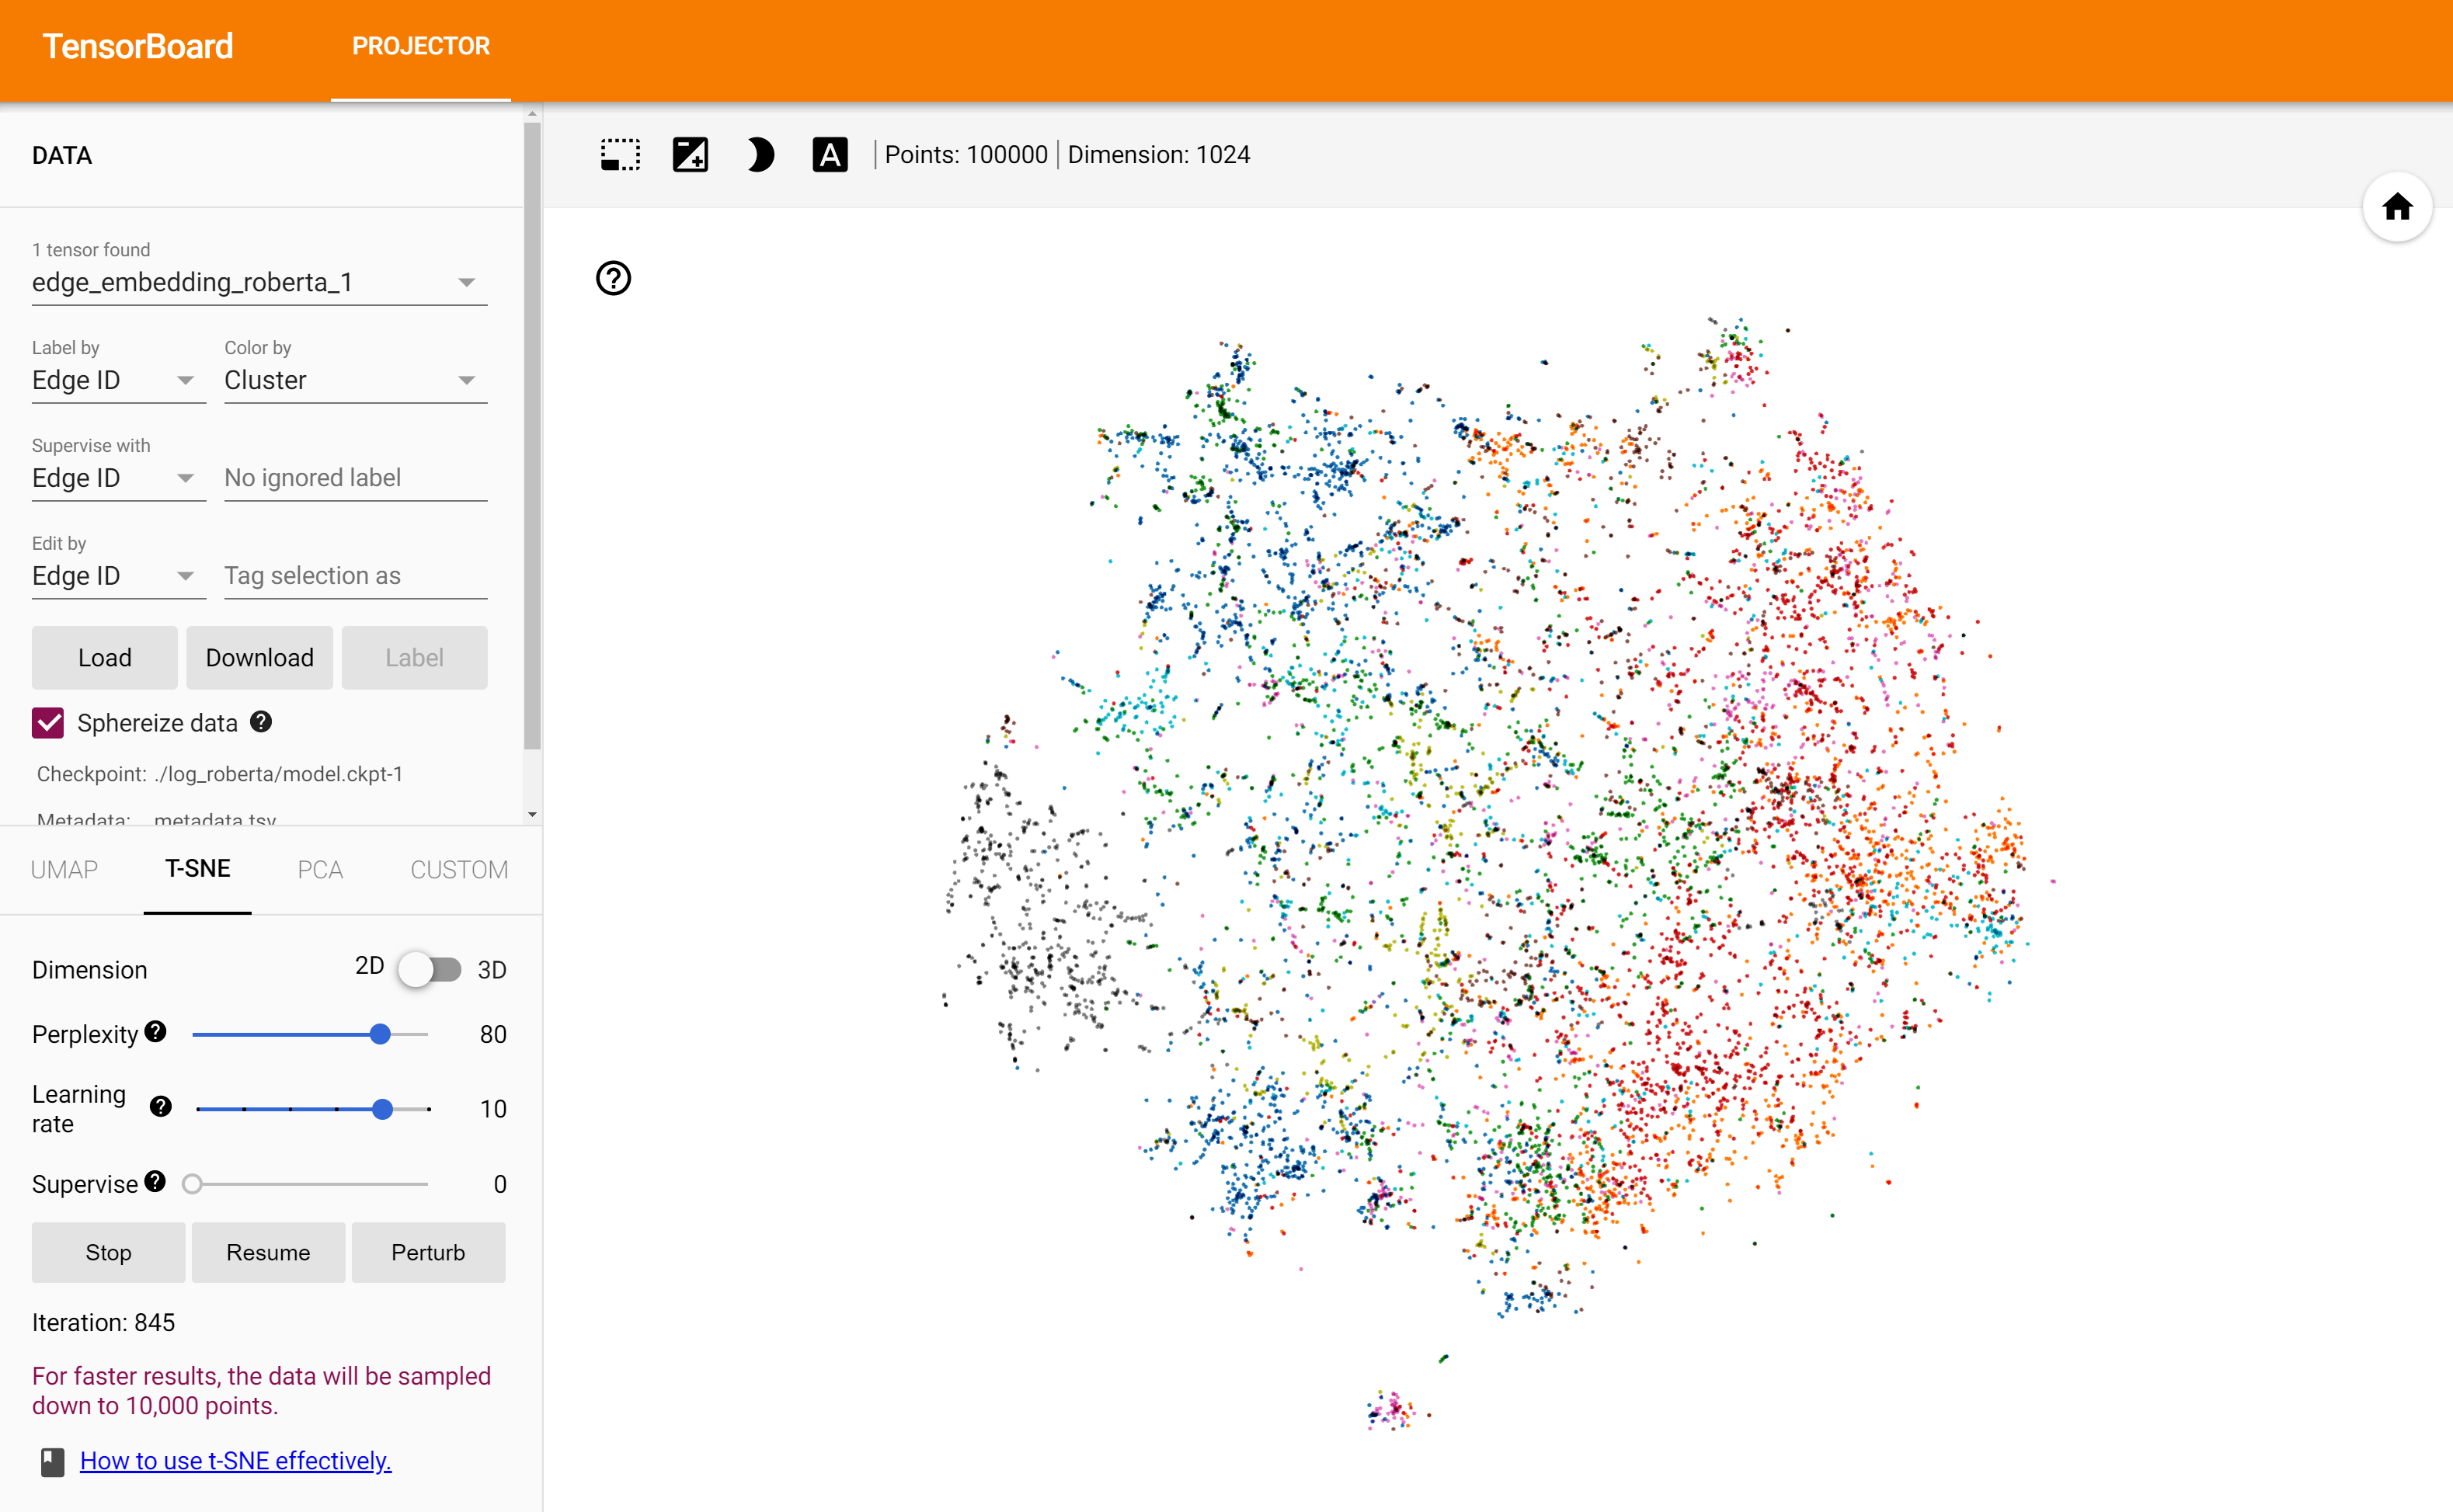

## Explore T-SNE 

`class sklearn.manifold.TSNE(n_components=2, perplexity=30.0, early_exaggeration=12.0, learning_rate=200.0, n_iter=1000, n_iter_without_progress=300, min_grad_norm=1e-07, metric=’euclidean’, init=’random’, verbose=0, random_state=None, method=’barnes_hut’, angle=0.5)`

important parameters:
- perplexity
- learning rate
- maximum number of iterations
- angle

In [67]:
embedding_ids = [edge_info[0] for edge_info in sent_embs_roberta]
embedding_mat = [edge_info[1] for edge_info in sent_embs_roberta]
embedding_mat = np.array(embedding_mat)
print(embedding_ids[0],embedding_mat[0]

('/c/en/0.22_inch_calibre-/r/IsA-/c/en/5.6_millimetres-0000',
 array([ 0.8228284 ,  0.20535082, -0.06794494, ...,  0.6916851 ,
        -0.04065184, -0.12090104], dtype=float32))

In [68]:
embedding_mat.shape

(5957575, 1024)

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
tsne.fit_transform(embedding_mat)
new_embed = tsne.embedding_

In [ ]:
new_embed.shape